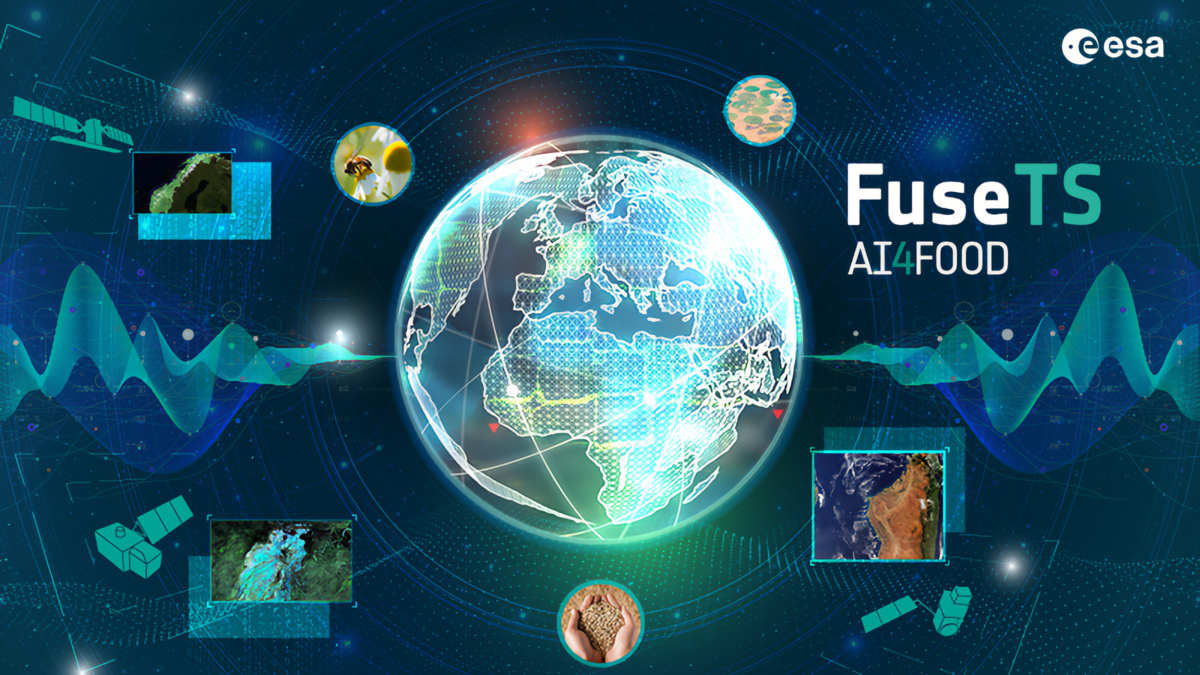

# Exploring the FuseTS Toolbox: Fusing Optical and SAR Data for Phenology Analysis

Welcome to the showcase of the FuseTS library, an integral part of the AI4FOOD project, presented at the BiDS conference. 

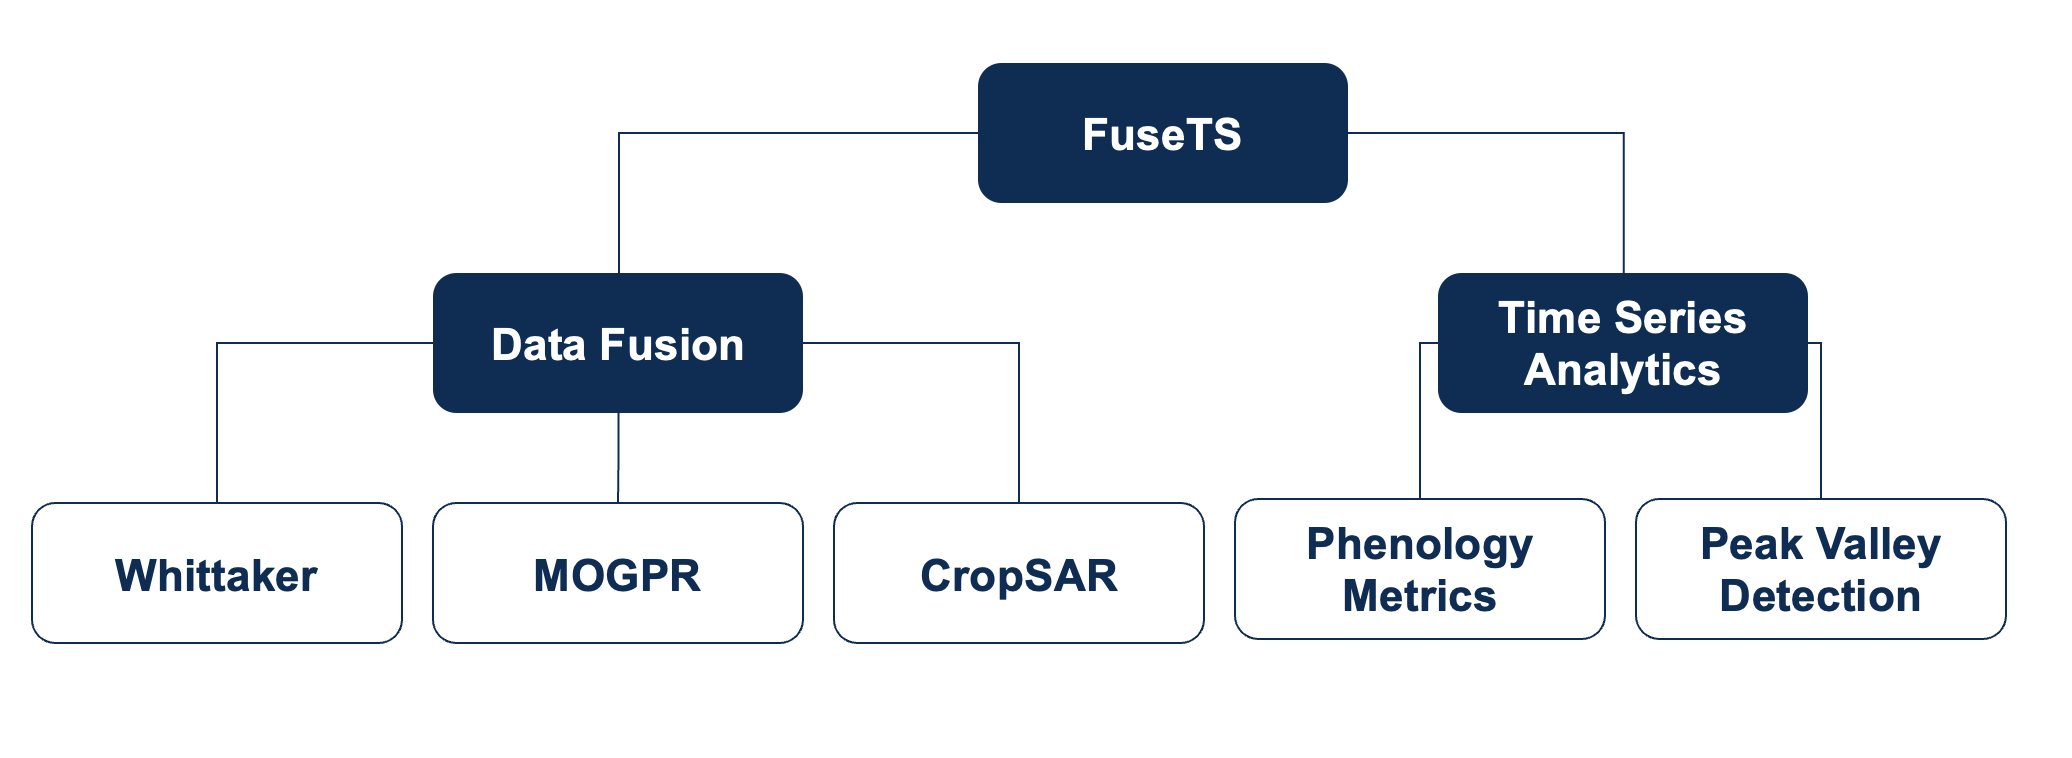

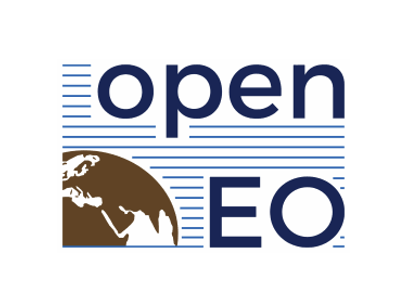 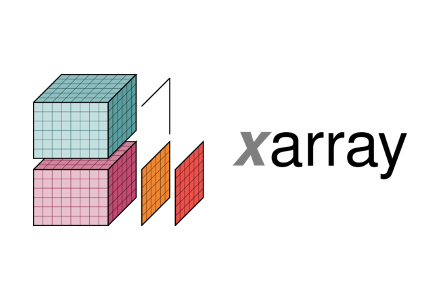

In this Jupyter notebook, we will demonstrate how the FuseTS library enables users to effectively fuse optical and SAR data, harnessing the power of fused data sets combined time series analytics for extracting valuable phenology information.

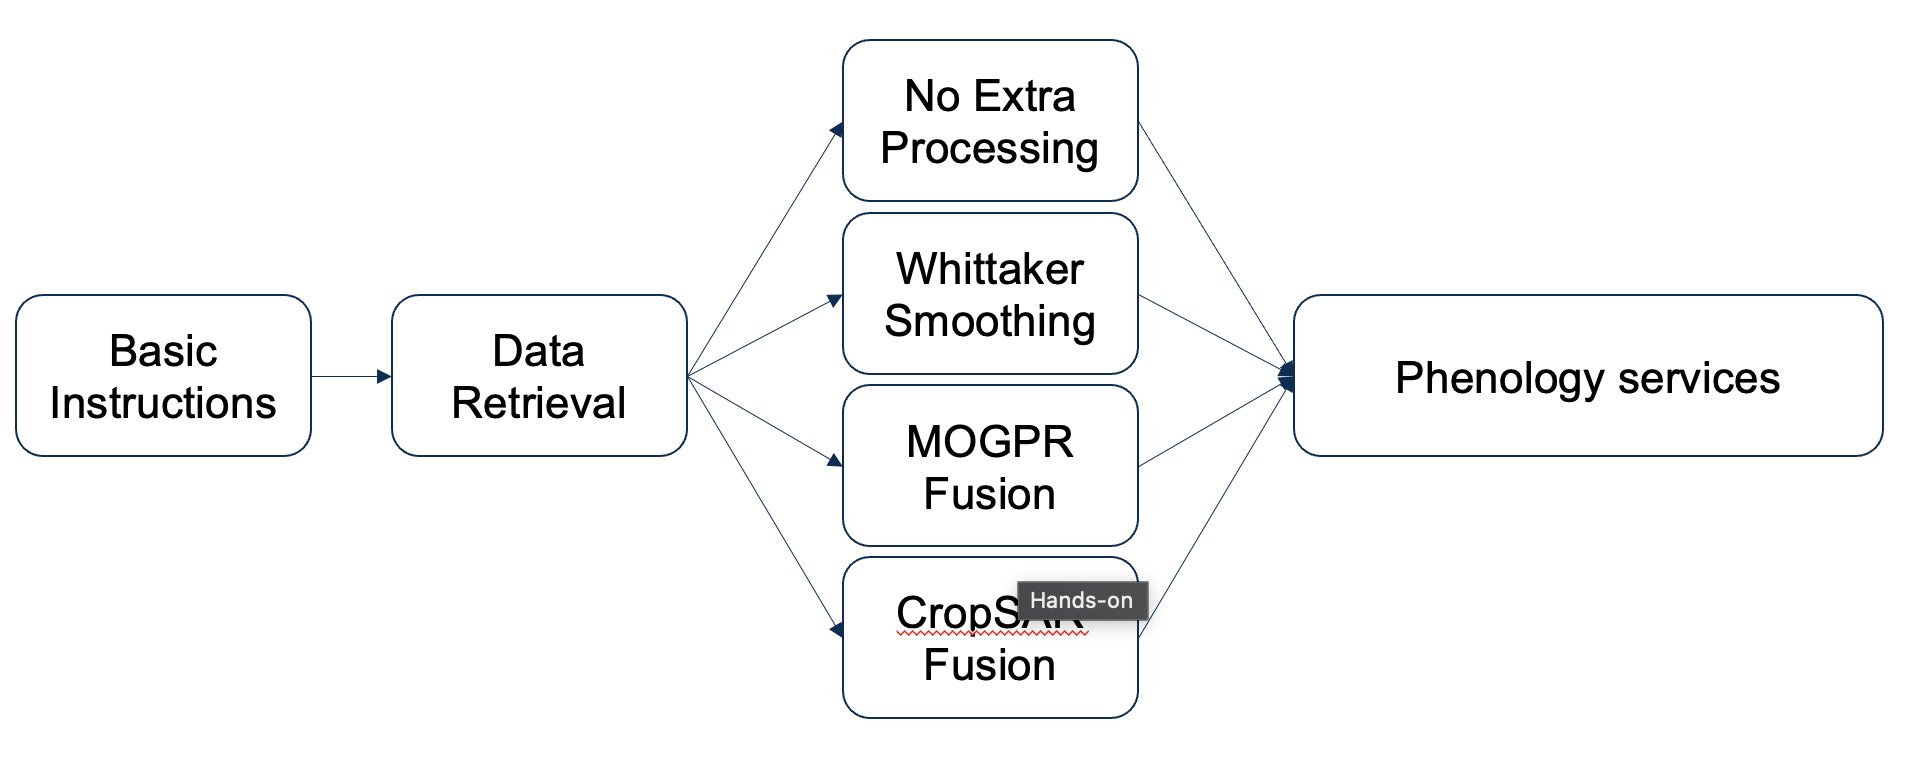

# Local Execution

## Setting up the environment

First of all we need to make sure that all our dependencies are correctly installed.


In [1]:
# Do not execute this cell when using the Docker image
!pip install numpy==1.23.5 cython
!pip install ../../../.
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Processing /Users/bramjanssen/projects/vito/FuseTS
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fusets: filename=fusets-2.0.2a1-py3-none-any.whl size=50371 sha256=0816446324288c627f28098abad2276666ce9977b37e219864de51525b67d1a2
  Stored in directory: /private/var/folders/50/09_2zmx12zj6ks4fdl4y9wgc0000gn/T/pip-ephem-wheel-cache-2bmxfwy2/wheels/b6/19/a9/92d4c884045c0183e2ee3ed4eee80cb741354972e677065ddb
Successfully built fusets
  Attempting uninstall: fusets
    Found existing installation: fusets 2.0.2a1
    Uninstalling fusets-2.0.2a1:
      Successfully uninstalled fusets-2.0.2a1

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, r

In [2]:
import itertools
import warnings
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import openeo
import pandas as pd
import xarray
from ipyleaflet import GeoJSON, Map, basemaps
from openeo.processes import eq
from openeo.rest.conversions import timeseries_json_to_pandas

from fusets.analytics import phenology
from fusets.mogpr import mogpr_1D
from fusets.whittaker import whittaker

import json

warnings.filterwarnings("ignore")

In [3]:
year = 2019

with open("field.geojson", "r") as input:
    spat_ext = json.load(input)
    input.close()
temp_ext = [f"{year}-01-01", f"{year}-12-30"]

Plot the area to see what we're working with.


In [4]:
center = np.mean(spat_ext["coordinates"][0], axis=0).tolist()[::-1]
zoom = 16

m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)
g = GeoJSON(
    data=spat_ext,
    style={
        "color": "red",
        "opacity": 1,
        "weight": 1.9,
        "dashArray": "9",
        "fillOpacity": 0.5,
    },
)
m.add(g)
m

Map(center=[41.773657928529644, -4.872032244992425], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [5]:
ndvi_output_file = "raw_s2_ndvi_field.nc"
# load the dataset and check it's structure
raw_ndvi_ds = xarray.load_dataset(ndvi_output_file)

Plot the raw NDVI time series, averaged across the parcel


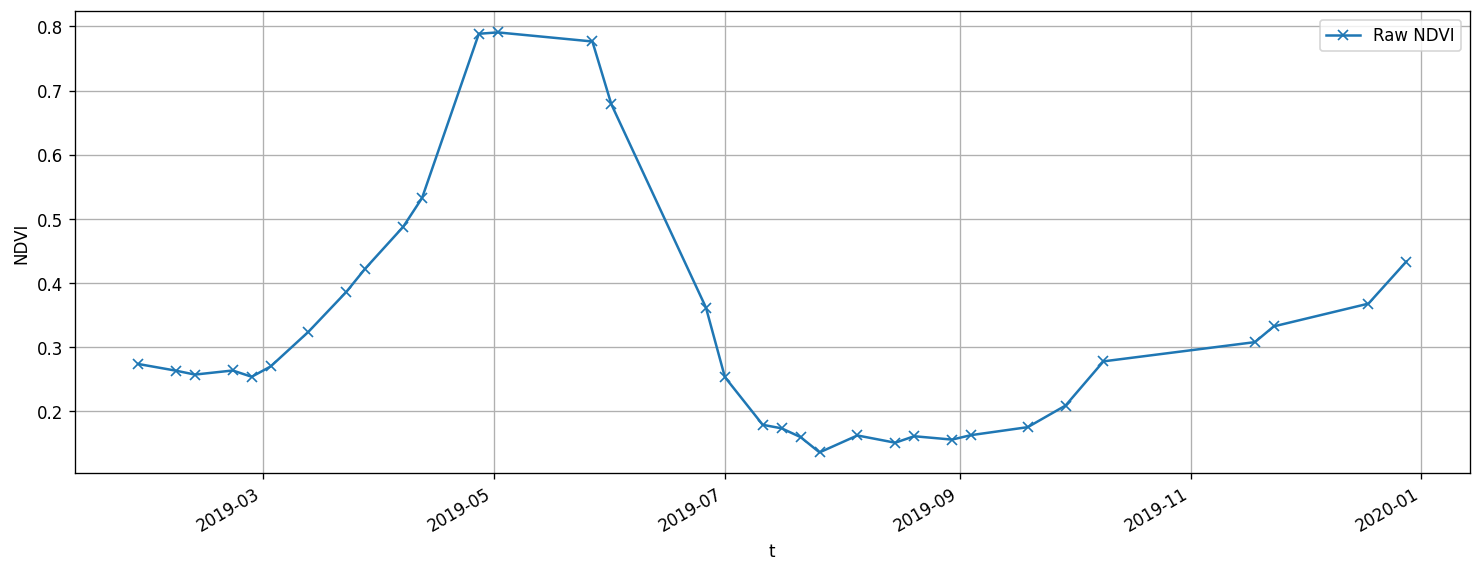

In [6]:
raw_ndvi = raw_ndvi_ds.NDVI.rename({"t": "time"})

fig, ax = plt.subplots(figsize=(15, 5), dpi=120)

raw_ndvi.median(dim=["x", "y"]).plot(ax=ax, marker="x", label="Raw NDVI")
ax.legend()
ax.grid()

## Creating a smoothed dataset using Whittaker

Whittaker smoother represents a computationally efficient reconstruction method for smoothing and gap-filling of time series which is why it is used here. (Eilers, P. H., 2003: A perfect smoother. Analytical chemistry, 75 (14), 3631–3636.)

In [7]:
# Make a prediction every 5 days
# to use the same dates as in the raw time series, just set the `prediction_period` to `None`
smoothed = whittaker(raw_ndvi, prediction_period="P5D", smoothing_lambda=10)

Plot the original raw NDVI as well as the smoothed NDVI


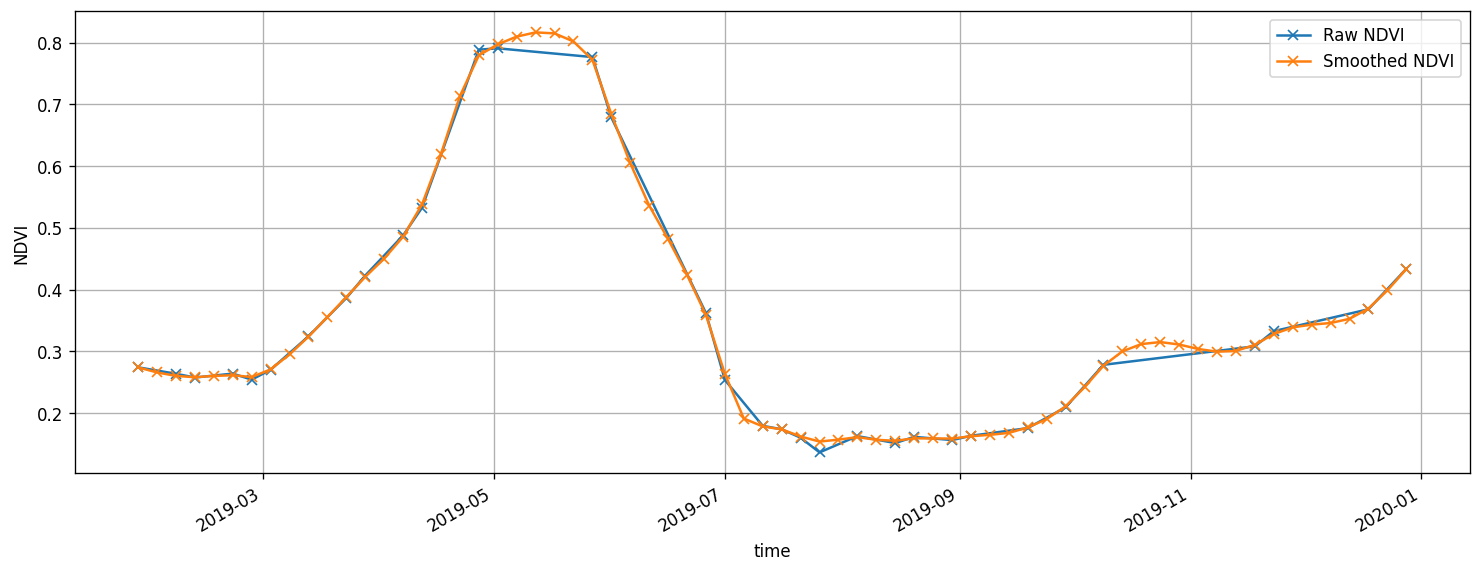

In [8]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=120)

raw_ndvi.median(dim=["x", "y"]).plot(ax=ax, marker="x", label="Raw NDVI", color="C0")
smoothed.median(dim=["x", "y"]).plot(ax=ax, marker="x", label="Smoothed NDVI", color="C1")
ax.legend()
ax.grid()

## Creating fused time series with MOGPR

In this section, we will begin the process of creating our first fused dataset using the MOGPR (Multi-Output Gaussian Process Regression) technique. The process uses probabilistic theory to describe the time series using families of functions in a non-parametric way, and extracts the correlation between different inputs in order to merge the information together. The probabilistic nature of the process also provides uncertainty levels.

The fusion process will involve combining Sentinel-1 (S1) RVI and Sentinel-2 (S2) NDVI data. To accomplish this, we will leverage the powerful capabilities of the FuseTS library.

### Reading the S1 RVI and S2 NVDI timeseries



In [9]:
# Show the downloaded tabular data, aggregated over parcel and over timestamp
output_file = "mogpr_input.csv"
mogpr_df = pd.read_csv(output_file)
mogpr_df["date"] = pd.to_datetime(mogpr_df["date"])
mogpr_df.set_index("date", inplace=True)
mogpr_df.head(10)

,NDVI,RVI_DESC,RVI_ASC
date,,,
2019-01-05 00:00:00+00:00,NaN,0.141821,0.036808
2019-01-06 00:00:00+00:00,NaN,0.130454,NaN
2019-01-11 00:00:00+00:00,NaN,0.129154,0.051692
2019-01-12 00:00:00+00:00,NaN,0.165680,NaN
2019-01-17 00:00:00+00:00,NaN,0.149493,0.037356
2019-01-18 00:00:00+00:00,NaN,0.140769,NaN
2019-01-23 00:00:00+00:00,NaN,0.139814,0.075868
2019-01-24 00:00:00+00:00,NaN,0.171226,NaN
2019-01-27 00:00:00+00:00,0.283416,NaN,NaN


(0.0, 1.0)

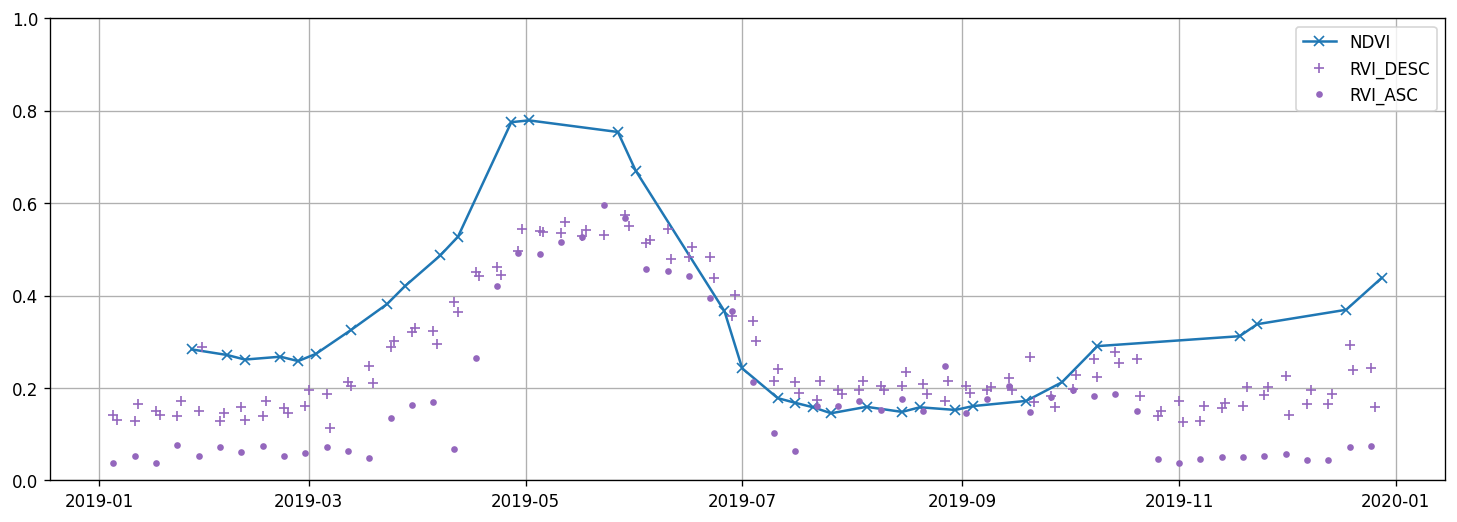

In [10]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=120)

style_dict = {
    "NDVI": dict(marker="x", color="C0"),
    "RVI_DESC": dict(marker="+", color="C4", lw=0),
    "RVI_ASC": dict(marker=".", color="C4", lw=0),
}

for col in mogpr_df.columns:
    ax.plot(mogpr_df[col].dropna(), label=col, **style_dict[col])

ax.legend()
ax.grid(True)
ax.set_ylim([0, 1])

### Executing MOGPR

In order to process the time series data, some additional preprocessing is required to execute the MOGPR algorithm. This includes extracting the different time steps that are available in the input data.

The step here may seem unnecessary, but it's merely transforming the data into a format which is expected by the `GPy` library containing the MOGPR logic.


In [11]:
# Use only 2 signals
signals = ["RVI_DESC", "NDVI"]

doy_step = 5
doy, data = [], []

# create integer-nature time vectors for all inputs
for signal in signals:
    doy.append(mogpr_df.index.day_of_year.to_numpy())
    data.append(mogpr_df[signal].to_numpy())

doy_min = np.min(list(itertools.chain(*doy)))
doy_max = np.max(list(itertools.chain(*doy)))
output_doy = np.arange(doy_min, doy_max, doy_step)
output_time = pd.to_datetime(output_doy, unit="D", origin=datetime(2019, 1, 1))

The logic behing the MOGPR algorithm is quite complex and we will not go into details. A good place to start learning more is [this tutorial](https://nbviewer.org/github/SheffieldML/notebook/blob/master/GPy/coregionalized_regression_tutorial.ipynb).

In principle, imagine the process doing the following:

1. the model finds non-parametric descriptions of the time-series using a family of functions
2. the model extracts the level of correlation between the inputs
3. the model constructs the non-parametric outputwith optimal hyper-parameters for describing the functions and taking the correlations into account


In [12]:
# run the MOGPR fit
master_ind = 1
out_mean, out_std, out_qflag, out_model = mogpr_1D(
    data_in=data, time_in=doy, master_ind=master_ind, output_timevec=output_doy, nt=1
)

Let's convert the output of the service to a pandas dataframe and plot the results.


In [13]:
# construct a pandas dataframe from the output
mogpr = pd.DataFrame({"NDVI": out_mean[master_ind], "NDVI_std": out_std[master_ind]})
mogpr["time"] = output_time
mogpr.set_index("time", inplace=True)

mogpr.head(10)

,NDVI,NDVI_std
time,,
2019-01-06,0.220987,0.023910
2019-01-11,0.230882,0.015539
2019-01-16,0.244002,0.010007
2019-01-21,0.260451,0.005273
2019-01-26,0.278005,0.002171
2019-01-31,0.235243,0.001159
2019-02-05,0.290009,0.000989
2019-02-10,0.257595,0.001099
2019-02-15,0.252513,0.001288


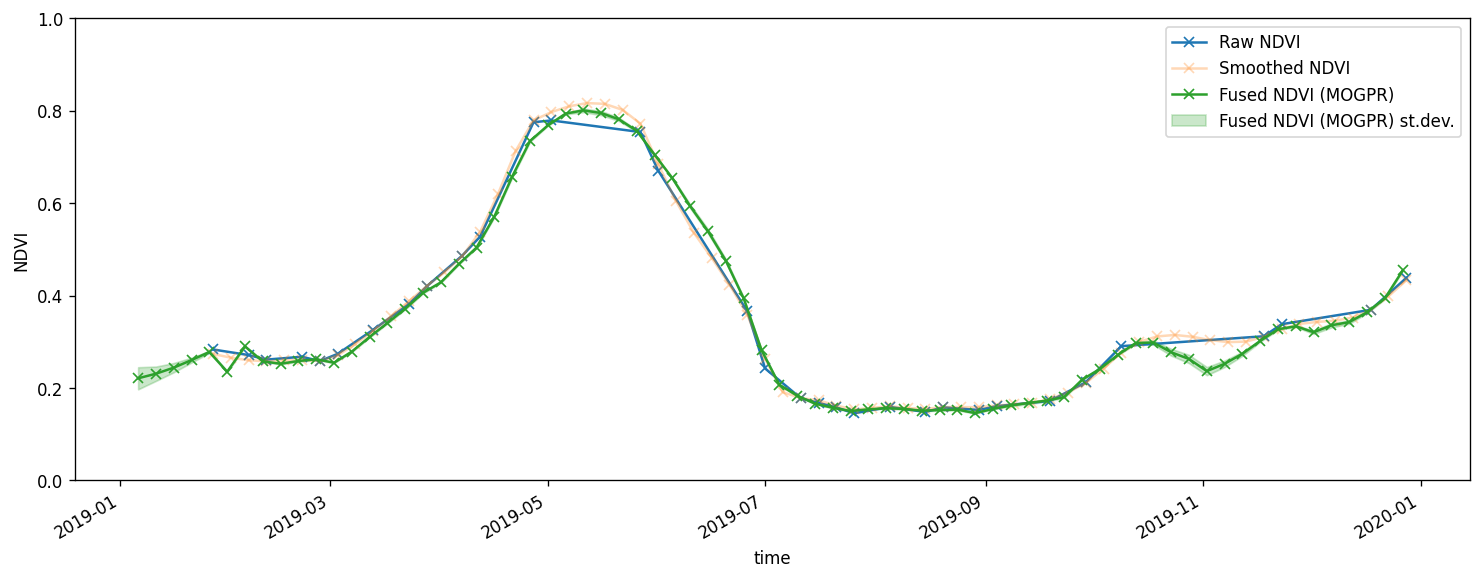

In [14]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=120)

ax.plot(mogpr_df["NDVI"].dropna(), "x-", color="C0", label="Raw NDVI")
smoothed.median(dim=["x", "y"]).plot(ax=ax, marker="x", label="Smoothed NDVI", color="C1", alpha=0.3)

ax.plot(mogpr["NDVI"], "x-", color="C2", label="Fused NDVI (MOGPR)")
ax.fill_between(
    x=mogpr.index,
    y1=mogpr["NDVI"] - mogpr["NDVI_std"],
    y2=mogpr["NDVI"] + mogpr["NDVI_std"],
    color="C2",
    alpha=0.25,
    label="Fused NDVI (MOGPR) st.dev.",
)

ax.set_ylim([0, 1])
ax.legend()

## Phenology calculation

In this final step, we will utilize both the raw and CropSAR-based time series data to extract valuable phenology information. To accomplish this, we will employ the `phenology` service. By leveraging this service, we can extract a range of essential metrics, including the start, peak, and end of the growing season.

The calculation is based on the [phenolopy]() python package.

![phenolopy](https://github.com/lewistrotter/Phenolopy/raw/main/documentation/images/pheno_explain.png?raw=true)


In [15]:
# run phenology on raw NDVI
raw_phenology = phenology(raw_ndvi)

# run phenology on Whittaker smoothed
whittaker_phenology = phenology(smoothed)

# run phenology on MOGPR
mogpr_phenology = phenology(mogpr.to_xarray().NDVI)

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of valley of season (vos) values and times.
> Calculating valley of season (vos) values.
> Calculating valley of season (vos) times.
> Success!

Beginning calculation of middle of season (mos) values (times not possible).
> Calculating middle of season (mos) values.
> Success!

Beginning calculation of base (bse) values (times not possible).
> Calculating base (bse) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning calculation of start of season (sos) values and time

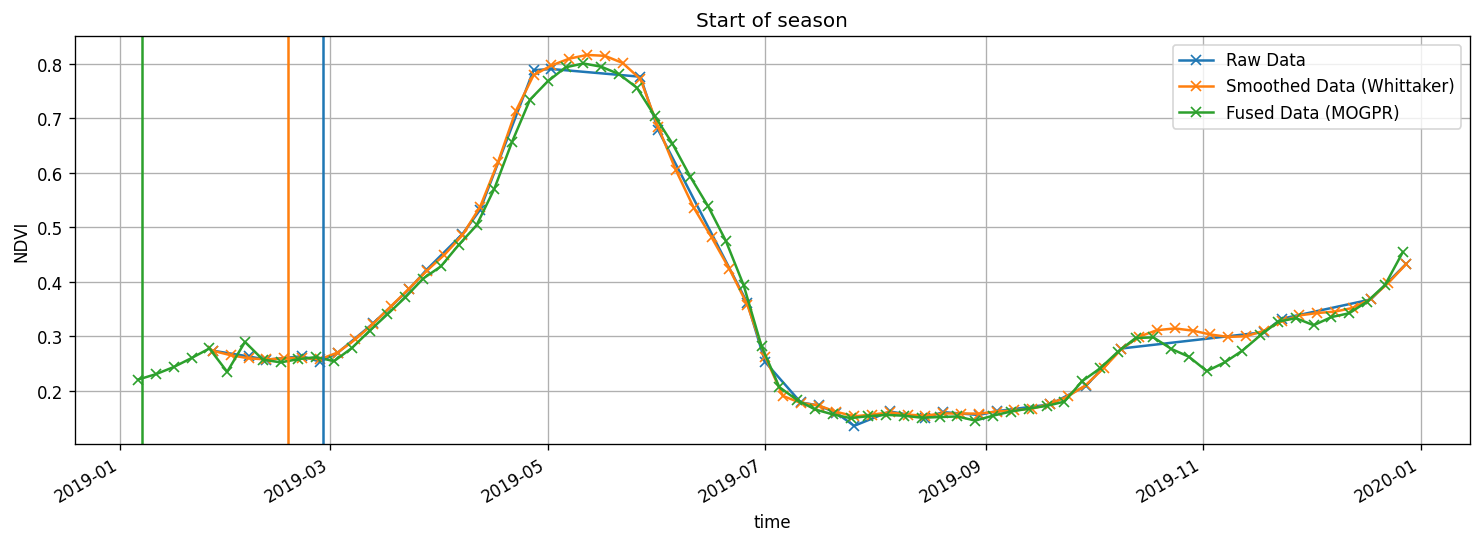

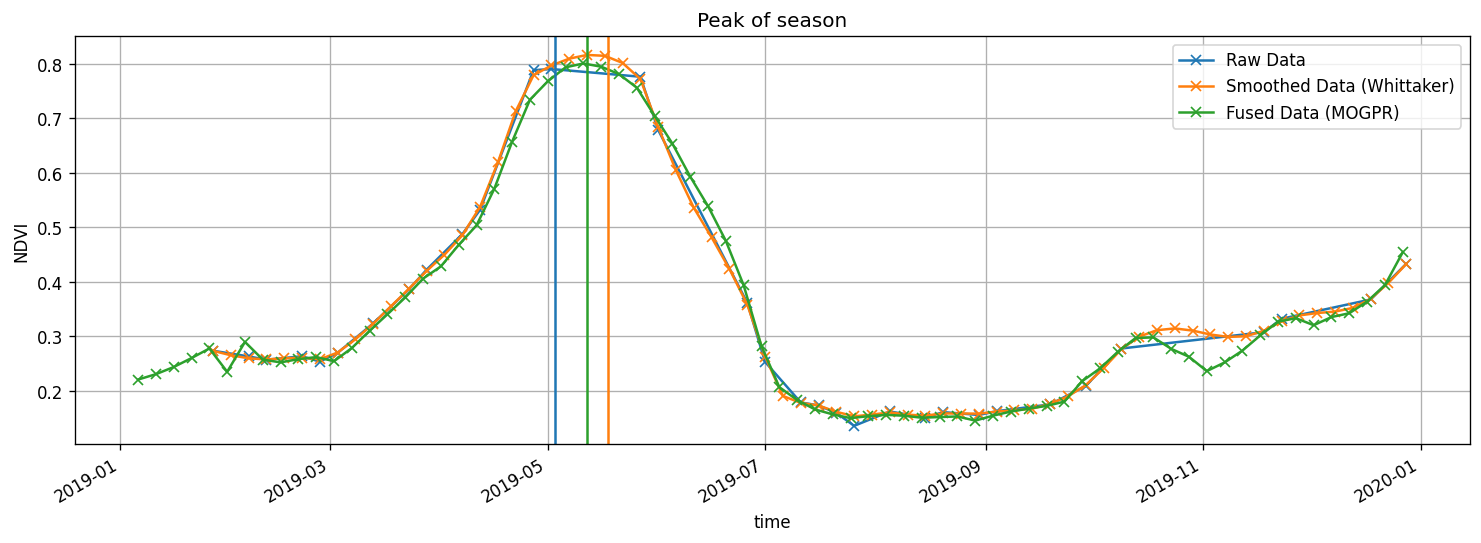

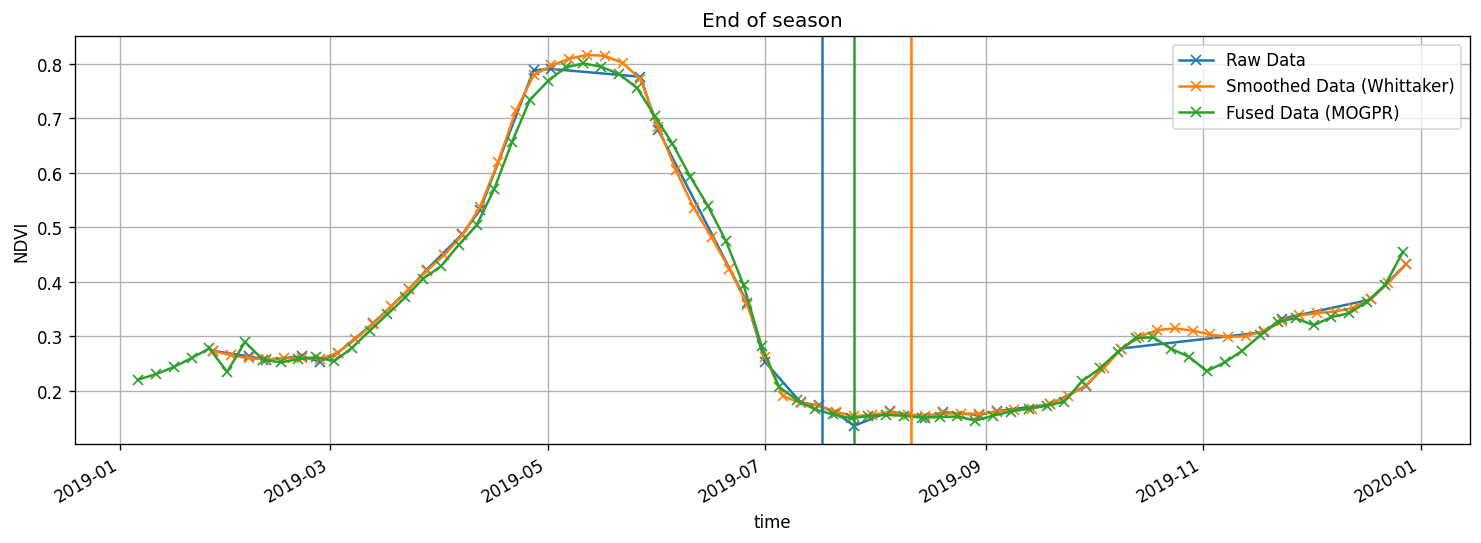

In [16]:
# utility function to extract phenology metrics
def get_phenology_metric(phenology_data, metric):
    if "x" in phenology_data.dims:
        metric_data = phenology_data[metric].median(["x", "y"]).values.take(0)
    else:
        metric_data = phenology_data[metric].values.take(0)

    return datetime(year, 1, 1) + timedelta(days=float(metric_data) if not float(np.isnan(metric_data)) else 0)


for title, metric in zip(["Start of season", "Peak of season", "End of season"], ["sos", "pos", "eos"]):
    fig, ax = plt.subplots(figsize=(15, 5), dpi=120)

    raw_ndvi.median(dim=["x", "y"]).plot(ax=ax, marker="x", color="C0", label="Raw Data")
    smoothed.median(dim=["x", "y"]).plot(ax=ax, marker="x", color="C1", label="Smoothed Data (Whittaker)")
    mogpr["NDVI"].plot(ax=ax, marker="x", color="C2", label="Fused Data (MOGPR)")
    ax.legend()
    ax.grid()

    ax.axvline(get_phenology_metric(raw_phenology, f"{metric}_times"), color="C0")
    ax.axvline(get_phenology_metric(whittaker_phenology, f"{metric}_times"), color="C1")
    ax.axvline(get_phenology_metric(mogpr_phenology, f"{metric}_times"), color="C2")
    ax.set_title(title)

The basic phenology metrics (Start Of Season(SOS), Peak Of Season(POS), End Of Season(EOS)) are presented above.
In this case, SOS and EOS are calculated using one of the available methodologies, first of slope. This allows to characterize the seasonality of the crop.

With this last step, an integral workflow is demonstrated: from the raw data acquisition and fused time series generation to the retrieval of phenology metrics.


# OpenEO Implementation
In this next section we demonstrate the usage of the FuseTS service in a full openEO workflow.|

In [17]:
connection = openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


In [18]:
phenology_output_file = "./phenology.nc"

In [19]:
service = "CropSAR_px"
namespace = "vito"
cropsar_cube = connection.datacube_from_process(
    service, namespace=namespace, geometry=spat_ext, startdate=temp_ext[0], enddate=temp_ext[1], version=2
)

In [20]:
service = "phenology"
namespace = "u:fusets"
phenology = connection.datacube_from_process(
    service, namespace=f"https://openeo.vito.be/openeo/1.1/processes/{namespace}/{service}", data=cropsar_cube
)

In [25]:
phenology_job = phenology.execute_batch(
    phenology_output_file,
    out_format="netcdf",
    title=f"FuseTS - CropSAR - Phenology",
    job_options={
        "udf-dependency-archives": [
            "https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/ai4food/fusets_venv.zip#tmp/venv",
            "https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/ai4food/fusets.zip#tmp/venv_static",
        ]
    },
)

0:00:00 Job 'j-231107bcb6b642fd9085d2bdc6ed92f4': send 'start'
0:00:21 Job 'j-231107bcb6b642fd9085d2bdc6ed92f4': queued (progress N/A)
0:00:26 Job 'j-231107bcb6b642fd9085d2bdc6ed92f4': queued (progress N/A)
0:00:33 Job 'j-231107bcb6b642fd9085d2bdc6ed92f4': queued (progress N/A)
0:00:41 Job 'j-231107bcb6b642fd9085d2bdc6ed92f4': queued (progress N/A)
0:00:51 Job 'j-231107bcb6b642fd9085d2bdc6ed92f4': queued (progress N/A)
0:01:04 Job 'j-231107bcb6b642fd9085d2bdc6ed92f4': queued (progress N/A)
0:01:19 Job 'j-231107bcb6b642fd9085d2bdc6ed92f4': queued (progress N/A)
0:01:38 Job 'j-231107bcb6b642fd9085d2bdc6ed92f4': queued (progress N/A)
0:02:03 Job 'j-231107bcb6b642fd9085d2bdc6ed92f4': queued (progress N/A)
0:02:33 Job 'j-231107bcb6b642fd9085d2bdc6ed92f4': running (progress N/A)
0:03:10 Job 'j-231107bcb6b642fd9085d2bdc6ed92f4': running (progress N/A)
0:03:57 Job 'j-231107bcb6b642fd9085d2bdc6ed92f4': running (progress N/A)
0:04:56 Job 'j-231107bcb6b642fd9085d2bdc6ed92f4': running (progress N/

## Exploring the results

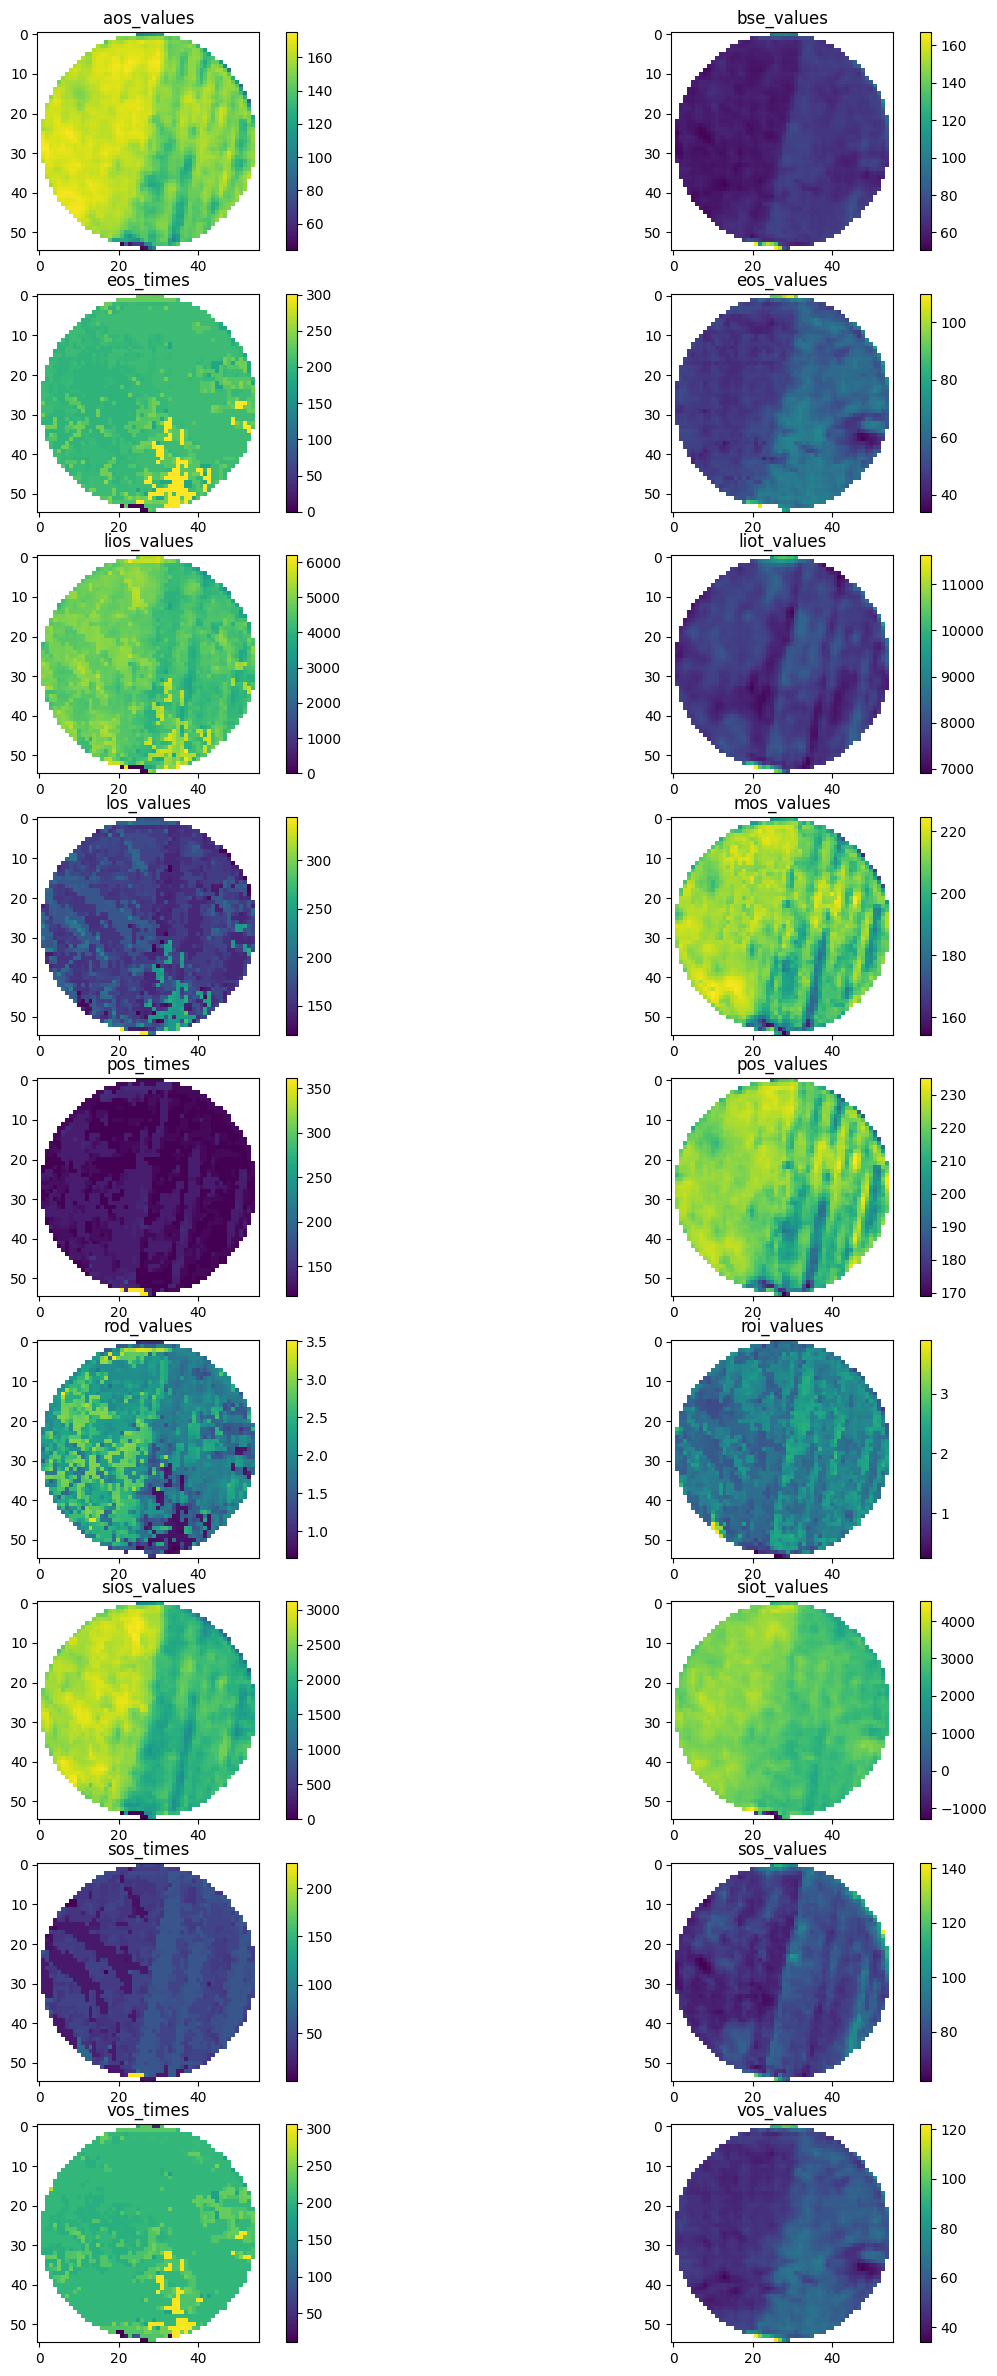

In [21]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import math

nc_file = nc.Dataset(phenology_output_file)
keys = [x for x in nc_file.variables.keys() if x not in ["phenology", "x", "y", "crs"]]
keys.sort()

lat = nc_file.variables["x"][:]
lon = nc_file.variables["y"][:]

ncols = 2
nrows = math.ceil(len(keys) / ncols)
col = 0
row = 0

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30))

for i, key in enumerate(keys):

    variable = nc_file.variables[key][0]
    im_pred = axs[row, col].imshow(variable)
    axs[row, col].set_title(key)
    fig.colorbar(im_pred, ax=axs[row, col])

    col = (col + 1) % ncols
    if col == 0:
        row += 1
plt.show()

# More examples? Contribute? 

Find us on GitHub: https://github.com/Open-EO/FuseTS